In [24]:
%pylab inline
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.genmod.families import Poisson
from torch.nn.modules.loss import PoissonNLLLoss
import torch.optim as optim
from lifelines.utils import concordance_index

Populating the interactive namespace from numpy and matplotlib


In [2]:
X = np.random.randn(3200, 3)
lam = np.exp(1*X[:,0] - 2*X[:,1] + 3*X[:,2])
y = np.random.poisson(lam=lam,size=len(X))
y = np.expand_dims(y, axis=1)

In [3]:
sm.GLM(y, X, family = Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3200
Model:                            GLM   Df Residuals:                     3197
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -5289.4
Date:                Thu, 31 May 2018   Deviance:                       2467.5
Time:                        22:17:58   Pearson chi2:                 3.28e+03
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9999      0.001    725.243      0.000       0.997       1.003
x2            -1.9997      0.001  -2270.641      0.000      -2.001      -1.998
x3             3.0005      0.001   3739.010      0.000       2.999       3.002
==============================================================================
"""

In [4]:
torch.manual_seed(1234)
device = torch.device("cpu")


bs = 32
num_batch = len(X) // bs

def get_batch(i):
    start = i*bs
    end = start + bs
    return torch.Tensor(X[start:end]), torch.Tensor(y[start:end])

In [5]:
class Exp(torch.nn.Module):
    def forward(self, input):
        return torch.exp(input)

model = torch.nn.Sequential(
    torch.nn.Linear(3,1)
).to(device)

#criterion = torch.nn.modules.loss.MSELoss()
criterion = PoissonNLLLoss(full=True)
opt = optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(num_batch):
        model.train()

        X_train, y_train = get_batch(i)
        opt.zero_grad()
        loss = criterion(model(X_train), y_train)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
    if epoch % 10 == 0:
        print(epoch_loss)
print(epoch_loss)

328609.9385623932
5466.751070022583
2031.515214920044
909.0079073905945
377.49513363838196
203.77448403835297
167.4330976009369
165.63228940963745
199.72883820533752
180.76400709152222
189.9216743707657


In [6]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)>

In [7]:
l = list(model.children())[0]

In [8]:
list(l.parameters())

[Parameter containing:
 tensor([[ 1.0074, -1.9984,  3.0108]]), Parameter containing:
 tensor(1.00000e-02 *
        [-2.9231])]

In [21]:
y_pred = pd.Series(np.ravel(torch.exp(model(torch.Tensor(X))).detach().numpy()))

0.9660501512267914

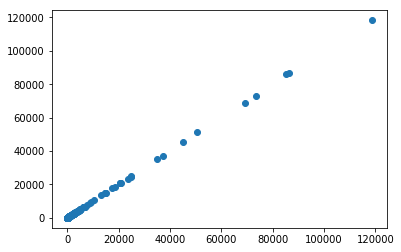

In [26]:
scatter(y_pred, y)
concordance_index(y, y_pred)

In [19]:
pd.Series(np.exp(y_pred))

/home/fredmonroe/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fredmonroe/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/fredmonroe/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

array([[ 9],
       [73],
       [ 0],
       ...,
       [ 2],
       [ 0],
       [ 0]])